In [1]:
# import tweets from csv
import os
import pandas as pd

input_path = os.path.join(os.path.dirname("__file__"), '..', 'tmp', 'tweets.csv')
df = pd.read_csv(input_path, encoding='utf-8')

/home/kento/tnkgs/automation/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/kento/tnkgs/automation/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_27983/3321257184.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster'] = kmeans.labels_
/tmp/ipykernel_27983/3321257184.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


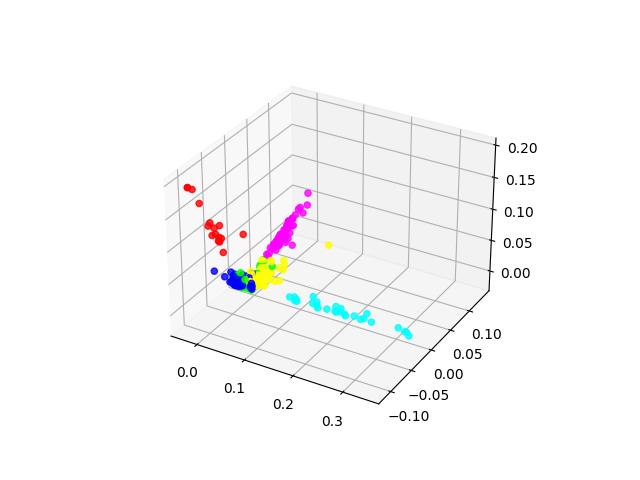

In [18]:
%matplotlib widget
import re
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

url_pattern = re.compile(r'https?://\S+|www\.\S+')

# 形態素解析を行い、名詞のみを抽出する関数
def tokenize(text):
    text = url_pattern.sub(r'', text)
    node = MeCab.Tagger().parse(text)
    tokens = []
    for line in node.split('\n'):
        if line == 'EOS':
            break
        else:
            [token, feature] = line.split('\t')
            features = feature.split(',')
            pos = features[0]
            if pos == '名詞':
                pos_detail_1 = features[1]
                if pos_detail_1 == '固有名詞' or \
                   pos_detail_1 == '一般' or \
                   pos_detail_1 == 'サ変接続' or \
                   pos_detail_1 == '形容動詞語幹' or \
                   pos_detail_1 == '副詞可能':
                    tokens.append(token)
    return tokens

df2 = df[df['favorite_count'] > 1000]

# TF-IDFによるベクトル化
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(df2['text'])

# K-meansによるクラスタリング
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

# 各ツイートが所属するクラスタをデータフレームに追加
df2['cluster'] = kmeans.labels_

# favorite_countの偏差値を求め、データフレームに追加
df_score = df2['favorite_count']
df_score_std = df_score.std(ddof=0)
df_score_mean = df_score.mean()
df2['favorite_count_zscore'] = df_score.map(lambda x: round((x - df_score_mean) / df_score_std * 10 + 50)).astype(int)


df3 = kmeans.transform(X)

pca = PCA(n_components=3)
pca.fit(df3)

feature = pca.transform(df3)

# 3次元でプロット
fig = plt.figure()
ax = plt.axes(projection='3d')

# 分かりやすくクラスタで色分け
color_codes = {0: '#00FF00', 1: '#FF0000', 2: '#0000FF', 3: '#FFFF00', 4: '#00FFFF', 5: '#FF00FF', 6: '#800000', 7: '#008000', 8: '#000080', 9: '#808000', 10: '#800080', 11: '#008080', 12: '#808080', 13: '#C0C0C0', 14: '#FF0000', 15: '#00FF00', 16: '#FFFF00', 17: '#0000FF', 18: '#FF00FF', 19: '#00FFFF', 20: '#800000', 21: '#008000', 22: '#808000', 23: '#000080', 24: '#800080', 25: '#008080', 26: '#808080', 27: '#C0C0C0', 28: '#FF0000', 29: '#00FF00', 30: '#FFFF00', 31: '#0000FF', 32: '#FF00FF', 33: '#00FFFF', 34: '#800000', 35: '#008000', 36: '#808000', 37: '#000080', 38: '#800080', 39: '#008080', 40: '#808080', 41: '#C0C0C0', 42: '#FF0000', 43: '#00FF00', 44: '#FFFF00', 45: '#0000FF', 46: '#FF00FF', 47: '#00FFFF', 48: '#800000', 49: '#008000', 50: '#808000', 51: '#000080', 52: '#800080', 53: '#008080', 54: '#808080', 55: '#C0C0C0', 56: '#FF0000', 57: '#00FF00', 58: '#FFFF00', 59: '#0000FF', 60: '#FF00FF', 61: '#00FFFF', 62: '#800000', 63: '#008000', 64: '#808000', 65: '#000080', 66: '#800080', 67: '#008080', 68: '#808080', 69: '#C0C0'}
colors = [color_codes[x] for x in kmeans.labels_]

ax.scatter(feature[:, 0], feature[:, 1], feature[:, 2], alpha=0.8, color=colors)

plt.show()

In [15]:
# クラスタ毎の単語とその出現率をcsvに出力
tokens = []
for i in range(6):
    print('cluster {}'.format(i))
    df_cluster = df2[df2['cluster'] == i]
    text = ' '.join(df_cluster['text'])
    text = url_pattern.sub(r'', text)
    node = MeCab.Tagger().parse(text)
    for line in node.split('\n'):
        if line == 'EOS':
            break
        else:
            [token, feature] = line.split('\t')
            features = feature.split(',')
            pos = features[0]
            if pos == '名詞':
                pos_detail_1 = features[1]
                if pos_detail_1 == '固有名詞' or \
                   pos_detail_1 == '一般' or \
                   pos_detail_1 == 'サ変接続' or \
                   pos_detail_1 == '形容動詞語幹' or \
                   pos_detail_1 == '副詞可能':
                    tokens.append({
                        'cluster': i,
                        'token': token,
                    })

df_tokens = pd.DataFrame(tokens)
df_tokens = df_tokens.groupby(['cluster', 'token']).size().reset_index(name='count')
df_tokens = df_tokens.sort_values(['cluster', 'count'], ascending=[True, False])
output_path = os.path.join(os.path.dirname("__file__"), '..', 'tmp', 'tokens.csv')
df_tokens.to_csv(output_path, index=False, encoding='utf-8')

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5


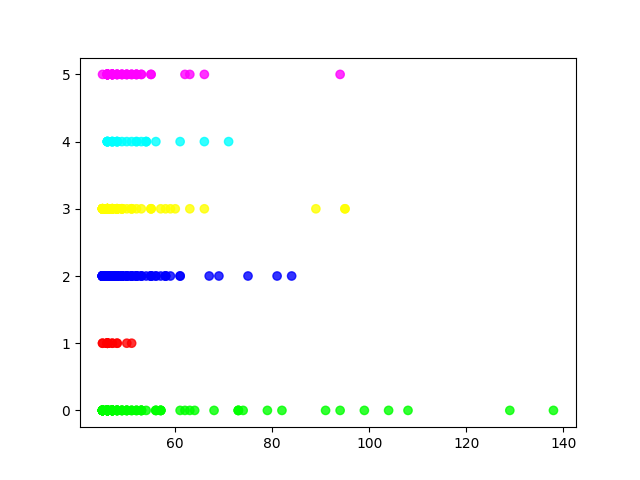

In [20]:
# df2（DataFrame）のfavorite_count_zscoreとclusterの関係をプロット
fig = plt.figure()
ax = plt.axes()

ax.scatter(df2['favorite_count_zscore'], df2['cluster'], alpha=0.8, color=colors)

plt.show()

In [ ]:
# df2をcsvに出力

output_path = os.path.join(os.path.dirname("__file__"), '..', 'tmp', 'tweets_cluster.csv')
df2.to_csv(output_path, index=False, encoding='utf-8')